### VGG16


In [1]:
import gc
import time
import os

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import regularizers
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay, f1_score

import seaborn as sn

from tensorflow.python.client import device_lib


from sklearn.model_selection import cross_val_score

from matplotlib import pyplot as plt

from numba import cuda 

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
train_dataset_path = '../spectrograms_dataset_old/train/'
test_dataset_path = '../spectrograms_dataset_old/test/'

In [4]:
validation_data_ratio = 0.2
image_shape = (224, 224)
batch_size = 64
# n_steps = traingen.samples // BATCH_SIZE
# n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 50

input_shape = None
label_shape = None

In [5]:
def load_train_ds():
    train_ds = keras.utils.image_dataset_from_directory(
        directory=train_dataset_path,
        labels='inferred',
        label_mode='binary',
        seed=1337,
        shuffle=True,
        validation_split=validation_data_ratio,
        subset='training',
        batch_size=batch_size,
        image_size=image_shape)
    
    return train_ds

In [6]:
def load_validation_ds():
    validation_ds = keras.utils.image_dataset_from_directory(
        directory=train_dataset_path,
        labels='inferred',
        label_mode='binary',
        seed=1337,
        shuffle=True,
        validation_split=validation_data_ratio,
        subset='validation',
        batch_size=1,
        image_size=image_shape)
    
    return validation_ds

In [7]:
def load_test_ds():
    test_ds = keras.utils.image_dataset_from_directory(
        directory=test_dataset_path,
        labels='inferred',
        label_mode='binary',
        seed=1337,
        shuffle=True,
        batch_size=1,
        image_size=image_shape)
    
    return test_ds

In [8]:
def load_datasets():
    train_ds = load_train_ds()
    validation_ds = load_validation_ds()
    test_ds = load_test_ds()
    
    return train_ds, validation_ds, test_ds

In [9]:
def get_input_shape(ds):
    input_shape = None
    for ims, lbs in ds.take(1):
        input_shape = ims[0].shape
        label_shape = lbs[0].shape
        print('input shape:', input_shape)
        print('label shape:', label_shape)
        break
        
    return input_shape

In [10]:
def get_classes(ds):
    ds.class_names

In [11]:
def print_samples(ds):
    plt.figure(figsize=(10, 10))
    
    for images, labels in ds.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(ds.class_names[int(labels[i])])
            plt.axis("off")

In [12]:
# def preprocess(images, labels, preprocess_input):
# #     return tf.keras.applications.resnet50.preprocess_input(images), labels
#     return preprocess_input(images), labels 

# preprocess = lambda images, labels, preprocess_input: preprocess_input(images, labels)

In [13]:
# a = lambda x, y: (x*x, y)

# a(2, 3)

In [14]:
def preprocess_datasets(train_ds, validation_ds, test_ds, preprocess_input):
    ## Preprocessing input
    train_dataset = train_ds.map(lambda images, labels:( preprocess_input(images), labels))
    validation_dataset = validation_ds.map(lambda images, labels: (preprocess_input(images), labels))
    test_dataset = test_ds.map(lambda images, labels: (preprocess_input(images), labels))
    
    return train_dataset, validation_dataset, test_dataset

In [15]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


In [16]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [17]:
# def build_model(input_shape, opt, base_model, flatten = True):
#     base_model.trainable = False

#     # Create a new 'top' of the model (i.e. fully-connected layers).
#     # This is 'bootstrapping' a new top_model onto the pretrained layers.
#     top_model = base_model.output
    
#     if flatten is True:
#         top_model = Flatten(name="flatten")(top_model)
#     else:
#         top_model = GlobalAveragePooling2D(name="GlobalAveragePooling2D")(top_model)
            
#     top_model = Dropout(0.6)(top_model)

#     top_model = Dense(512, activation='relu', name="fc1", 
#                       kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
#                       bias_regularizer=regularizers.L2(1e-4),
#                       activity_regularizer=regularizers.L2(1e-5))(top_model)
    
#     top_model = Dropout(0.7)(top_model)
    
#     output_layer = Dense(1, activation='sigmoid', name="prediction")(top_model)
    
#     # Group the convolutional base and new fully-connected layers into a Model object.
#     model = Model(inputs=base_model.input, outputs=output_layer)

#     # Compiles the model for training.
#     model.compile(optimizer=opt, 
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
    
#     print(model.summary())

#     return model

In [18]:
def build_model(input_shape, opt, base_model, flatten = True):
    base_model.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = base_model.output
    
    if flatten is True:
        top_model = Flatten(name="flatten")(top_model)
    else:
        top_model = GlobalAveragePooling2D(name="GlobalAveragePooling2D")(top_model)
            
#     top_model = Dropout(0.6)(top_model)

    top_model = Dense(512, activation='relu', name="fc1", 
                      kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                      bias_regularizer=regularizers.L2(1e-4),
                      activity_regularizer=regularizers.L2(1e-5))(top_model)


    
#     top_model = Dropout(0.7)(top_model)
    
    output_layer = Dense(1, activation='sigmoid', name="prediction")(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=base_model.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=opt, 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    print(model.summary())

    return model

In [19]:
def print_parameters(batch_size, lr, epochs):
    print('batch size:', batch_size)
    print('learning rate:', lr)
    print('epochs:', epochs)

In [20]:
# EarlyStopping
def early_stop(patience):
    return EarlyStopping(monitor='val_accuracy',
                           patience=patience,
                           restore_best_weights=True,
                           mode='max', 
                           verbose=1)

In [21]:
def test_model(test_ds, model):
    predictions = np.array([])
    labels =  np.array([])

    for x, y in test_ds:
        predictions = np.concatenate([predictions, model.predict(x, verbose=0).reshape(1,-1)[0]])
        labels = np.concatenate([labels, np.array(y[0])])

    predictions = [0 if x < 0.5 else 1 for x in predictions]

    accuracy = accuracy_score(labels, predictions)
    print("Test Accuracy:", accuracy)
    
    f1score = f1_score(labels, predictions)
    print("F1 score:", f1score)
    

#     confusion_mtx = confusion_matrix(labels, predictions)

    ConfusionMatrixDisplay.from_predictions(labels, predictions)
    
    RocCurveDisplay.from_predictions(labels, predictions)
    
#     print(confusion_mtx)

#     ax = plt.axes()
#     sn.heatmap(confusion_mtx, annot=True,annot_kws={"size": 25}, cmap="Blues", ax = ax, fmt='d')
#     ax.set_title('Test Accuracy', size=14)
#     plt.show()

In [22]:
def run(datasets, input_shape, preprocess_input, base_model, flatten = True, lr = 0.001, epochs=100, patience=15):
    train_ds, validation_ds, test_ds = preprocess_datasets(*datasets, preprocess_input)
    
    print_parameters(batch_size, lr, epochs)
    
    opt = keras.optimizers.Adam(learning_rate=lr)
    model = build_model(input_shape, opt, base_model, flatten)
    
    history = model.fit(
        train_ds, 
        epochs=epochs, 
        validation_data=validation_ds, 
        #     callbacks=[tl_checkpoint_1, early_stop],
        callbacks=[early_stop(patience)],
        verbose=1)
    
    plot_accuracy(history)
    
    plot_loss(history)

    test_model(test_ds, model)
    
    del opt, model, history, train_ds, validation_ds, test_ds
    
    gc.collect()

## Load data

In [23]:
datasets = load_datasets()

Found 4616 files belonging to 2 classes.
Using 3693 files for training.
Found 4616 files belonging to 2 classes.
Using 923 files for validation.
Found 1155 files belonging to 2 classes.


In [24]:
input_shape = get_input_shape(datasets[0])

input shape: (224, 224, 3)
label shape: (1,)


# MODELS

### VGG16

batch size: 64
learning rate: 0.001
epochs: 100
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool 

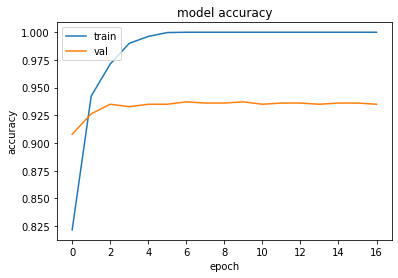

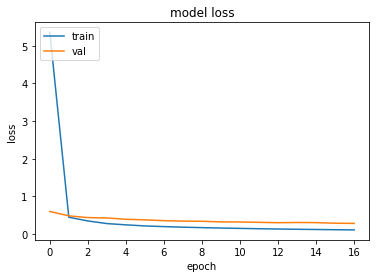

Test Accuracy: 0.935930735930736
F1 score: 0.9406099518459069


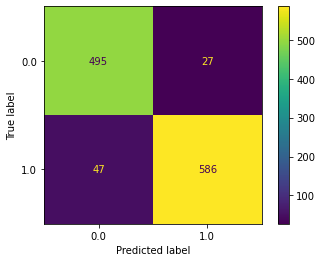

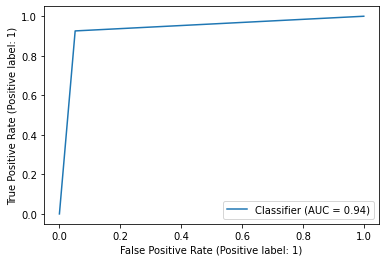

In [25]:
base_model = tf.keras.applications.VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)

preprocess = tf.keras.applications.vgg16.preprocess_input

run(datasets=datasets, input_shape=input_shape, preprocess_input=preprocess, base_model=base_model, 
    flatten = True, lr = 0.001, epochs=100, patience=10)
#     True, 0.0001, 100, 15)

### VGG19

batch size: 64
learning rate: 0.001
epochs: 100
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_poo

Epoch 32/100
58/58 [==============================] - 160s 3s/step - loss: 0.2448 - accuracy: 0.9634 - val_loss: 0.3212 - val_accuracy: 0.9166
Epoch 33/100
58/58 [==============================] - 161s 3s/step - loss: 0.2744 - accuracy: 0.9532 - val_loss: 0.3676 - val_accuracy: 0.9198
Epoch 34/100
58/58 [==============================] - 159s 3s/step - loss: 0.1934 - accuracy: 0.9859 - val_loss: 0.3422 - val_accuracy: 0.9242
Epoch 35/100
58/58 [==============================] - 159s 3s/step - loss: 0.1637 - accuracy: 0.9968 - val_loss: 0.3069 - val_accuracy: 0.9328
Epoch 36/100
58/58 [==============================] - 159s 3s/step - loss: 0.1507 - accuracy: 0.9976 - val_loss: 0.3245 - val_accuracy: 0.9274
Epoch 37/100
58/58 [==============================] - 159s 3s/step - loss: 0.1413 - accuracy: 0.9978 - val_loss: 0.3175 - val_accuracy: 0.9296
Epoch 38/100
58/58 [==============================] - 160s 3s/step - loss: 0.1332 - accuracy: 0.9976 - val_loss: 0.3269 - val_accuracy: 0.9274

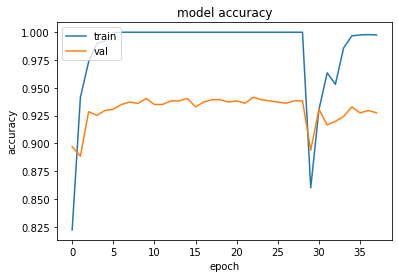

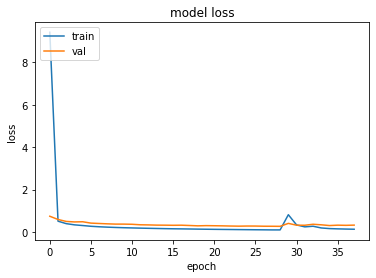

Test Accuracy: 0.929004329004329
F1 score: 0.9341894060995184


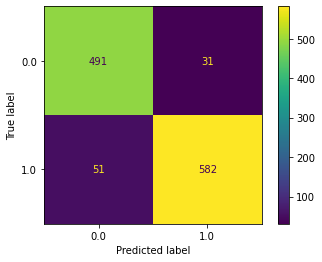

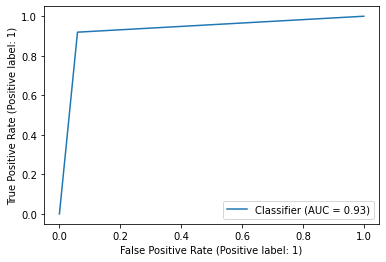

In [26]:
# batch size 64, lr 0.001, 
base_model = tf.keras.applications.VGG19(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)

preprocess = tf.keras.applications.vgg19.preprocess_input

run(datasets=datasets, input_shape=input_shape, preprocess_input=preprocess, base_model=base_model, 
    flatten = True, lr = 0.001, epochs=100, patience=15)

### ResNet50V2

In [27]:
# batch size 64, lr 0.001, 

base_model = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)

preprocess = tf.keras.applications.resnet_v2.preprocess_input

run(datasets=datasets, input_shape=input_shape, preprocess_input=process, base_model=base_model, 
    flatten = False, lr = 0.001, epochs=100, patience=15)

NameError: name 'process' is not defined

### InceptionResNetV2

In [ ]:
# batch size 64, lr 0.001, 
base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)

preprocess = tf.keras.applications.inception_resnet_v2.preprocess_input

run(datasets=datasets, input_shape=input_shape, preprocess_input=preprocess, base_model=base_model, 
    flatten = False, lr = 0.001, epochs=100, patience=15)

### MobileNetV2

In [ ]:
# batch size 64, lr 0.001, 
base_model = tf.keras.applications.MobileNetV2(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)

preprocess = tf.keras.applications.mobilenet_v2.preprocess_input

run(datasets=datasets, input_shape=input_shape, preprocess_input=preprocess, base_model=base_model, 
    flatten = False, lr = 0.001, epochs=100, patience=15)

### DenseNet169

In [ ]:
# batch size 64, lr 0.001, 
base_model = tf.keras.applications.DenseNet169(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)

preprocess = tf.keras.applications.densenet.preprocess_input

run(datasets=datasets, input_shape=input_shape, preprocess_input=preprocess, base_model=base_model, 
    flatten = False, lr = 0.001, epochs=100, patience=15)

### EfficientNetB2

In [ ]:
# batch size 64, lr 0.001, 
base_model = tf.keras.applications.EfficientNetB2(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)

preprocess = tf.keras.applications.efficientnet.preprocess_input

run(datasets=datasets, input_shape=input_shape, preprocess_input=preprocess, base_model=base_model, 
    flatten = False, lr = 0.001, epochs=100, patience=15)

### Xception

In [ ]:
# batch size 64, lr 0.001, 
base_model = tf.keras.applications.Xception(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)

preprocess = tf.keras.applications.xception.preprocess_input

run(datasets=datasets, input_shape=input_shape, preprocess_input=preprocess, base_model=base_model, 
    flatten = False, lr = 0.001, epochs=100, patience=15)

In [ ]:
# batch size 64, lr 0.001, 
base_model = tf.keras.applications.nasnet.NASNetMobile(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)

preprocess = tf.keras.applications.nasnet.preprocess_input

run(datasets=datasets, input_shape=input_shape, preprocess_input=preprocess, base_model=base_model, 
    flatten = False, lr = 0.001, epochs=100, patience=15)